In [1]:
import os

from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from deepcell_tracking.metrics import calculate_summary_stats

In [2]:
baxter_path = '../benchmarking/Baxter/benchmarks.csv'
embedtrack_path = '../benchmarking/EmbedTrack/benchmarks.csv'
deepcell_path = '../benchmarking/DeepCell/benchmarks.csv'
tracx_path = '../benchmarking/TracX/benchmarks.csv'

sum_columns = ['correct_division', 'mismatch_division',
    'false_positive_division', 'false_negative_division', 'total_divisions',
    'aa_tp', 'aa_total', 'te_tp', 'te_total']
mean_columns = ['DET', 'SEG', 'TRA']

In [21]:
paths = [deepcell_path, baxter_path, embedtrack_path, tracx_path]
dfs = []
for path in paths:
    sdf = pd.read_csv(path, index_col=0)
    
    # Rollup data for each model version
    sdf_a = sdf[['model'] + sum_columns].groupby('model').sum().reset_index()
    sdf_b = sdf[['model'] + mean_columns].groupby('model').mean().reset_index()
    sdf = sdf_a.merge(sdf_b, on='model')
    dfs.append(sdf)
    
df = pd.concat(dfs).reset_index(drop=True)

In [22]:
def calculate_stats(row):
    cols = ['correct_division', 'false_positive_division', 'false_negative_division', 'total_divisions',
            'aa_tp', 'aa_total', 'te_tp', 'te_total']
    d = row[cols].to_dict()
    return pd.Series(calculate_summary_stats(**d))

df = df.join(df.apply(calculate_stats, axis=1))

In [23]:
df

,model,correct_division,mismatch_division,false_positive_division,false_negative_division,total_divisions,aa_tp,aa_total,te_tp,te_total,DET,SEG,TRA,Division Recall,Division Precision,Division F1,Mitotic branching correctness,Fraction missed divisions,Association Accuracy,Target Effectiveness
0,Deepcell - Deepcell,151.0,11.0,10.0,16.0,178.0,47007.0,48390.0,48364.0,49775.0,0.990764,0.923929,0.989835,0.90,0.94,0.92,0.85,0.09,0.97,0.97
1,Deepcell - GT,169.0,1.0,3.0,8.0,178.0,47908.0,48390.0,49293.0,49775.0,1.000000,1.000000,0.999636,0.95,0.98,0.97,0.94,0.04,0.99,0.99
2,Baxter - Deepcell,86.0,7.0,30.0,85.0,178.0,47610.0,48390.0,48911.0,49775.0,0.988279,0.919609,0.987211,0.50,0.74,0.60,0.43,0.48,0.98,0.98
3,Baxter - GT,104.0,6.0,13.0,68.0,178.0,48171.0,48390.0,49493.0,49775.0,0.997080,0.996160,0.996567,0.60,0.89,0.72,0.56,0.38,1.00,0.99
4,EmbedTrack - Fluo-N2DH-GOWT1,0.0,0.0,15.0,108.0,108.0,4850.0,29504.0,5192.0,30321.0,0.238841,0.179327,0.231180,0.00,0.00,0.00,0.00,1.00,0.16,0.17
5,EmbedTrack - Fluo-N2DH-SIM+,0.0,7.0,1500.0,171.0,178.0,25167.0,48390.0,26326.0,49775.0,0.826697,0.397969,0.779315,0.00,0.00,0.00,0.00,0.96,0.52,0.53
6,EmbedTrack - Fluo-N2DL-HeLa,108.0,10.0,533.0,60.0,178.0,39605.0,48390.0,40739.0,49775.0,0.816220,0.641730,0.815163,0.64,0.17,0.27,0.15,0.34,0.82,0.82
7,TracX - Deepcell,42.0,45.0,121.0,91.0,178.0,45986.0,48390.0,47343.0,49775.0,0.990764,0.923929,0.989102,0.32,0.26,0.28,0.17,0.51,0.95,0.95
8,TracX - GT,42.0,56.0,36.0,80.0,178.0,47293.0,48390.0,48678.0,49775.0,1.000000,1.000000,0.998686,0.34,0.54,0.42,0.27,0.45,0.98,0.98


In [24]:
stats_columns = ['Division Precision', 'Division Recall', 'Division F1', 'Mitotic branching correctness', 'Association Accuracy',
       'Target Effectiveness', 'DET', 'SEG', 'TRA']
stats = df[['model']+stats_columns].melt(
    id_vars='model',
    value_vars=stats_columns,
    var_name='metric'
    )

stats_grid = df[['model']+stats_columns].set_index('model')

div_columns = ['correct_division', 'mismatch_division', 'false_positive_division', 'false_negative_division']
divisions = df[['model']+div_columns].melt(
    id_vars='model',
    value_vars=div_columns,
    var_name='metric'
    )

In [25]:
# Norm for tab20 colormap
norm = Normalize(vmin=0, vmax=19)

# GT segs are even numbers
colors = {
    'Baxter - GT': cm.tab20(norm(0)),
    'Baxter - Deepcell': cm.tab20(norm(1)),
    'Deepcell - GT': cm.tab20(norm(2)),
    'Deepcell - Deepcell': cm.tab20(norm(3)),
    'EmbedTrack - Fluo-N2DH-GOWT1': cm.tab20(norm(5)),
    'EmbedTrack - Fluo-N2DH-SIM+': cm.tab20(norm(7)),
    'EmbedTrack - Fluo-N2DL-HeLa': cm.tab20(norm(9)),
    'TracX - GT': cm.tab20(norm(10)),
    'TracX - Deepcell': cm.tab20(norm(11))
}

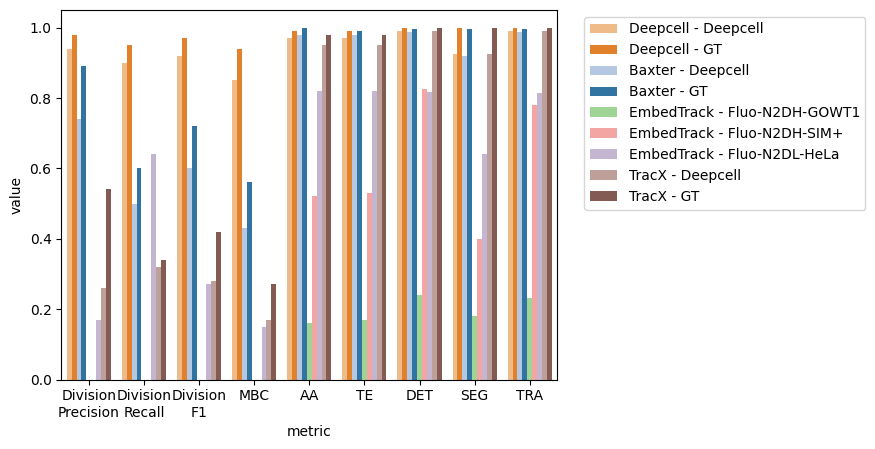

In [26]:
labels = {
    'Division Precision': 'Division\nPrecision',
    'Division Recall': 'Division\nRecall',
    'Division F1': 'Division\nF1',
    'Mitotic branching correctness': 'MBC',
    'Association Accuracy': 'AA',
    'Target Effectiveness': 'TE'
}

sns.barplot(
    data=stats.replace(labels),
    x='metric',
    y='value',
    hue='model',
    palette=colors
) 
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [32]:
stats_grid.style.background_gradient(cmap='magma', vmin=0, vmax=1).set_precision(3)

/tmp/ipykernel_13452/2172259909.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  stats_grid.style.background_gradient(cmap='magma', vmin=0, vmax=1).set_precision(3)


,Division Precision,Division Recall,Division F1,Mitotic branching correctness,Association Accuracy,Target Effectiveness,DET,SEG,TRA
model,,,,,,,,,
Deepcell - Deepcell,0.940,0.900,0.920,0.850,0.970,0.970,0.991,0.924,0.990
Deepcell - GT,0.980,0.950,0.970,0.940,0.990,0.990,1.000,1.000,1.000
Baxter - Deepcell,0.740,0.500,0.600,0.430,0.980,0.980,0.988,0.920,0.987
Baxter - GT,0.890,0.600,0.720,0.560,1.000,0.990,0.997,0.996,0.997
EmbedTrack - Fluo-N2DH-GOWT1,0.000,0.000,0.000,0.000,0.160,0.170,0.239,0.179,0.231
EmbedTrack - Fluo-N2DH-SIM+,0.000,0.000,0.000,0.000,0.520,0.530,0.827,0.398,0.779
EmbedTrack - Fluo-N2DL-HeLa,0.170,0.640,0.270,0.150,0.820,0.820,0.816,0.642,0.815
TracX - Deepcell,0.260,0.320,0.280,0.170,0.950,0.950,0.991,0.924,0.989
TracX - GT,0.540,0.340,0.420,0.270,0.980,0.980,1.000,1.000,0.999
